In [2]:
from __future__ import annotations
import zipfile
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt

In [3]:
MAIN_DIR = "/Users/alex/Desktop/CS/Internships and Research/DBF/python_tools/data/windTunnel/11_24_2023"
THRUST_ZIP = MAIN_DIR + "/11_24_2023_AP_DATA/11.22.23_ ValidationTests.zip"
BLACKBOX_ZIP = MAIN_DIR + "/WInd Tunnel Blackbox Data.zip"
OUTPUT_DIR = MAIN_DIR + "/processed"

In [4]:
MIN_THROTTLE = 1065
MAX_THROTTLE = 2011

In [5]:
thrust_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(THRUST_ZIP) as z:
    for name in filter(lambda x: x.endswith(".csv"), z.namelist()):
        data = z.read(name)
        df = pd.read_csv(StringIO(data.decode('utf-8')))
        df = df[df.CODE == 0]
        df.reset_index(inplace=True, drop=True) 
        thrust_dfs[name.replace("RUN1.csv", "").split("/")[1]] = df

In [6]:
thrust_dfs.keys()

dict_keys(['AT7215_15x14x3_12S_45', 'AT7215_16x16_12S_45', 'AT5330_16x16_12S_30', 'AT7215_15x14x3_12S_10', 'AT7215_16x14_12S_35', 'AT7215_16x14_12S_25', 'AT5330_15x14x3_12S_20', 'AT5330_15x14x3_12S_30', 'AT5330_16x16_12S_40', 'AT5330_16x14_12S_20RUN2.csv', 'AT7215_16x14_12S_45', 'AT5330_16x14_12S_30', 'AT5330_16x14_12S_20', 'AT5330_15x14x3_12S_15', 'AT7215_16x14_12S_Static', 'AT7215_15x14x3_12S_25', 'AT7215_15x14x3_12S_35', 'AT7215_16x14_12S_10', 'AT7215_15x14x3_12S_30', 'AT7215_15x14x3_12S_20', 'AT7215_16x14_12S_15', 'AT5330_15x14x3_12S_10', 'AT5330_16x14_12S_25', 'AT5330_16x14_12S_35', 'AT7215_15x14x3_12S_Static', 'AT5330_15x14x3_12S_Static', 'AT7215_16x14_12S_50', 'AT7215_16x14_12S_40', 'AT5330_16x14_12S_25RUN2.csv', 'AT5330_15x14x3_12S_35', 'AT5330_15x14x3_12S_25', 'AT7215_15x14x3_12S_15', 'AT7215_16x14_12S_20', 'AT7215_16x14_12S_30', 'AT5330_16x16_12S_35', 'AT7215_16x16_12S_50', 'AT7215_15x14x3_12S_40', 'AT7215_15x14x3_12S_50'])

In [7]:
blackbox_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(BLACKBOX_ZIP) as z:
    for name in filter(lambda x: x.endswith(".csv"), z.namelist()):
        # len 6: WInd Tunnel Blackbox Data/AT7215/APC/16x14/AT7215_16x14_12S_25/AT7215_16x14_12S_25_1.csv
        # len 5: WInd Tunnel Blackbox Data/AT5330/APC/16x14/At5330_16x14_12S_20.csv
        # len 4: WInd Tunnel Blackbox Data/AT5330/Master Air Screw/At5330_15x14x3_12S_10.csv
        name = name.replace(".csv", "")
        parts = name.split("/")
        run = "1"
        if len(parts) == 6:
            _, motor, manufacturer, prop, _, description = parts
            _, _, battery, airspeed, run = description.split("_")
        elif len(parts) == 5:
            _, motor, manufacturer, prop, description = parts
            _, _, battery, airspeed = description.split("_")
        elif len(parts) == 4:
            _, motor, manufacturer, description = parts
            _, prop, battery, airspeed = description.split("_")
        else:
            raise Exception("Unexpected number of nested directories: " + str(len(parts)))
        
        data = z.read(name + ".csv")
        df = pd.read_csv(StringIO(data.decode('utf-8')))
        df.dropna(inplace=True, subset=['motor[0]'])
        df["motor"] = motor
        df["manufacturer"] = manufacturer
        df["prop"] = prop
        df["battery"] = battery
        df["airspeed"] = airspeed
        df["run"] = run
        df.rename(columns={"motor[0]": "throttle"}, inplace=True)
        blackbox_dfs[description.replace('At', "AT").replace("static", "Static")] = df

In [8]:
blackbox_dfs.keys()

dict_keys(['AT5330_16x14_12S_20', 'AT5330_16x14_12S_25', 'AT5330_16x14_12S_30', 'AT5330_16x14_12S_35', 'AT5330_16x16_12S_30', 'AT5330_16x16_12S_35', 'AT5330_16x16_12S_40', 'AT5330_15x14x3_12S_10', 'AT5330_15x14x3_12S_15', 'AT5330_15x14x3_12S_20', 'AT5330_15x14x3_12S_25', 'AT5330_15x14x3_12S_30', 'AT5330_15x14x3_12S_35', 'AT5330_15x14x3_12S_Static', 'AT7215_16x14_12S_10', 'AT7215_16x14_12S_15', 'AT7215_16x14_12S_20', 'AT7215_16x14_12S_25_1', 'AT7215_16x14_12S_25_2', 'AT7215_16x14_12S_30', 'AT7215_16x14_12S_35', 'AT7215_16x14_12S_40', 'AT7215_16x14_12S_45', 'AT7215_16x14_12S_50', 'AT7215_16x14_12S_Static', 'AT7215_16x16_12S_45', 'AT7215_16x16_12S_50', 'AT7215_15x14x3_12S_10', 'AT7215_15x14x3_12S_15', 'AT7215_15x14x3_12S_20', 'AT7215_15x14x3_12S_25', 'AT7215_15x14x3_12S_30', 'AT7215_15x14x3_12S_35', 'AT7215_15x14x3_12S_40', 'AT7215_15x14x3_12S_45', 'AT7215_15x14x3_12S_50', 'AT7215_15x14x3_12S_Static'])

In [9]:
blackbox_dfs["AT7215_16x14_12S_25_1"].head()

,loopIteration,time (us),axisRate[0],axisRate[1],axisRate[2],axisP[0],axisP[1],axisP[2],axisI[0],axisI[1],...,sens7Temp,escRPM,escTemperature,rxUpdateRate,motor,manufacturer,prop,battery,airspeed,run
0,21536,176425479,0,0,0,0,0,0,-1,-3,...,-1250,3818,32,142,AT7215,APC,16x14,12S,25,1
1,21568,176457533,0,0,0,0,0,0,-1,-3,...,-1250,3818,32,142,AT7215,APC,16x14,12S,25,1
2,21570,176459534,0,0,0,0,0,0,-1,-3,...,-1250,3818,32,142,AT7215,APC,16x14,12S,25,1
3,21572,176461538,0,0,0,0,0,0,-1,-3,...,-1250,3818,32,142,AT7215,APC,16x14,12S,25,1
4,21574,176463543,0,0,0,0,0,0,-1,-3,...,-1250,3818,32,142,AT7215,APC,16x14,12S,25,1


In [10]:
for col in blackbox_dfs["AT7215_16x14_12S_25_1"].columns:
    print(col)

loopIteration
time (us)
axisRate[0]
axisRate[1]
axisRate[2]
axisP[0]
axisP[1]
axisP[2]
axisI[0]
axisI[1]
axisI[2]
axisD[0]
axisD[1]
axisD[2]
axisF[0]
axisF[1]
axisF[2]
fwAltP
fwAltI
fwAltD
fwAltOut
fwPosP
fwPosI
fwPosD
fwPosOut
rcData[0]
rcData[1]
rcData[2]
rcData[3]
rcCommand[0]
rcCommand[1]
rcCommand[2]
rcCommand[3]
vbat (V)
amperage (A)
BaroAlt (cm)
rssi
gyroADC[0]
gyroADC[1]
gyroADC[2]
accSmooth[0]
accSmooth[1]
accSmooth[2]
attitude[0]
attitude[1]
attitude[2]
throttle
servo[0]
servo[1]
servo[2]
servo[3]
servo[4]
servo[5]
servo[6]
servo[7]
servo[8]
servo[9]
servo[10]
servo[11]
servo[12]
servo[13]
servo[14]
servo[15]
navState
navFlags
navEPH
navEPV
navPos[0]
navPos[1]
navPos[2]
navVel[0]
navVel[1]
navVel[2]
navTgtVel[0]
navTgtVel[1]
navTgtVel[2]
navTgtPos[0]
navTgtPos[1]
navTgtPos[2]
navSurf
navAcc[0]
navAcc[1]
navAcc[2]
energyCumulative (mAh)
flightModeFlags (flags)
stateFlags (flags)
failsafePhase (flags)
rxSignalReceived
rxFlightChannelsValid
hwHealthStatus
powerSupplyImpedance
sa

<Axes: >

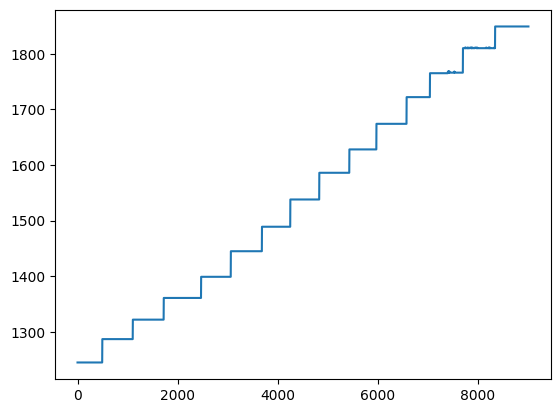

In [11]:
blackbox_dfs["AT7215_16x14_12S_25_1"]['throttle'].plot()

In [12]:
thrust_dfs["AT7215_16x14_12S_25"]

,RUN,TP,CODE,DYNAMIC PRESSURE,TS Temp,BALANCE Temp,N1,N2,S1,S2,A1,R1,Lift,Drag,Pitch,Yaw,Side,Roll
0,1,2,0,7.899,62.941,67.209,-0.001,0.001,0.001,-0.001,-0.034,0.0,-0.072,-1.344,0.585,-0.531,0.078,0
1,1,3,0,7.915,63.299,67.161,-0.001,0.001,0.001,-0.002,-0.064,0.0,-0.120,-2.552,0.561,-0.527,0.172,0
2,1,4,0,7.920,63.512,67.121,0.000,0.001,0.001,-0.002,-0.095,0.0,-0.150,-3.772,0.517,-0.706,0.234,0
3,1,5,0,7.940,63.553,67.091,0.000,0.001,0.001,-0.003,-0.130,0.0,-0.159,-5.176,0.562,-0.858,0.298,0
4,1,6,0,7.944,63.690,67.049,0.000,0.002,0.001,-0.003,-0.166,0.0,-0.167,-6.601,0.614,-0.974,0.355,0
5,1,7,0,7.965,63.597,66.996,0.000,0.002,0.001,-0.004,-0.213,0.0,-0.193,-8.465,0.659,-1.094,0.431,0
6,1,8,0,7.976,63.713,66.946,0.000,0.002,0.001,-0.004,-0.261,0.0,-0.212,-10.359,0.751,-1.167,0.494,0
7,1,9,0,7.995,63.893,66.915,0.000,0.002,0.001,-0.005,-0.315,0.0,-0.217,-12.529,0.826,-1.274,0.568,0
8,1,10,0,8.011,63.795,66.864,0.000,0.002,0.001,-0.005,-0.370,0.0,-0.239,-14.684,0.883,-1.389,0.644,0
9,1,11,0,8.038,63.901,66.828,0.000,0.002,0.001,-0.006,-0.418,0.0,-0.238,-16.603,0.896,-1.475,0.713,0


<Axes: >

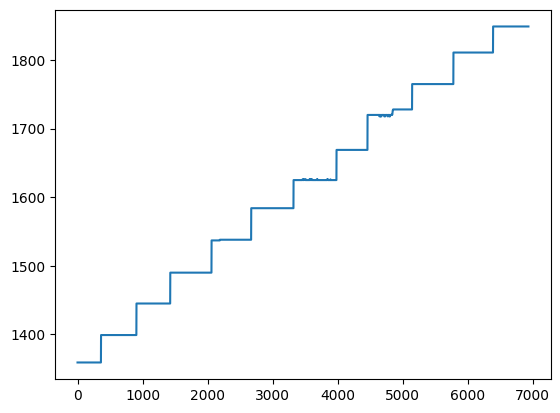

In [13]:
blackbox_dfs["AT5330_16x14_12S_20"]['throttle'].plot()

In [14]:
thrust_dfs["AT5330_16x14_12S_20"]

,RUN,TP,CODE,DYNAMIC PRESSURE,TS Temp,BALANCE Temp,N1,N2,S1,S2,A1,R1,Lift,Drag,Pitch,Yaw,Side,Roll
0,1.0,3.0,0.0,5.188,78.326,86.419,-0.001,0.000,-0.003,0.002,0.063,0.0,0.064,2.494,0.292,1.053,0.018,0.0
1,1.0,4.0,0.0,5.175,78.061,86.379,-0.001,0.000,-0.003,0.003,0.079,0.0,0.098,3.105,0.316,1.181,-0.023,0.0
2,1.0,5.0,0.0,5.164,77.803,86.370,-0.002,0.001,-0.003,0.003,0.095,0.0,0.146,3.772,0.451,1.320,-0.042,0.0
3,1.0,6.0,0.0,5.161,77.783,86.338,-0.002,0.001,-0.003,0.003,0.095,0.0,0.157,3.768,0.548,1.304,-0.041,0.0
4,1.0,7.0,0.0,5.149,77.916,86.289,-0.002,0.001,-0.003,0.004,0.115,0.0,0.185,4.534,0.496,1.421,-0.077,0.0
5,1.0,8.0,0.0,5.139,77.742,86.234,-0.002,0.001,-0.004,0.004,0.133,0.0,0.191,5.245,0.487,1.669,-0.086,0.0
6,1.0,9.0,0.0,5.124,77.976,86.187,-0.001,0.000,-0.004,0.005,0.158,0.0,0.180,6.243,0.232,1.792,-0.136,0.0
7,1.0,10.0,0.0,5.109,78.211,86.153,0.001,-0.002,-0.002,0.004,0.182,0.0,0.068,7.203,-0.754,1.454,-0.282,0.0
8,1.0,11.0,0.0,5.096,78.564,86.120,0.000,-0.001,-0.003,0.005,0.206,0.0,0.156,8.185,-0.498,1.787,-0.255,0.0
9,1.0,12.0,0.0,5.084,78.697,86.080,-0.000,-0.001,-0.003,0.005,0.229,0.0,0.212,9.076,-0.554,1.739,-0.328,0.0


In [15]:
# find non common df names
thrust_only_dfs = set(thrust_dfs.keys()).difference(set(blackbox_dfs.keys()))
print(thrust_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(thrust_dfs.keys()))
print(blackbox_only_dfs)

{'AT5330_16x14_12S_20RUN2.csv', 'AT5330_16x14_12S_25RUN2.csv', 'AT7215_16x14_12S_25'}
{'AT7215_16x14_12S_25_2', 'AT7215_16x14_12S_25_1'}


In [16]:
blackbox_dfs["AT7215_16x14_12S_25"] = blackbox_dfs["AT7215_16x14_12S_25_1"] # other run is blank, so this becomes the canonical one
thrust_dfs["AT5330_16x14_12S_25"] = thrust_dfs["AT5330_16x14_12S_25RUN2.csv"] # manual inspection of the data yields this matches the blackbox data
thrust_dfs["AT5330_16x14_12S_20"] = thrust_dfs["AT5330_16x14_12S_20RUN2.csv"] # neither one matched the blackbox data, but this one was closer

In [17]:
# find common df names
common_dfs = set(thrust_dfs.keys()).intersection(set(blackbox_dfs.keys()))
print(common_dfs)

{'AT5330_16x14_12S_30', 'AT7215_15x14x3_12S_35', 'AT7215_16x14_12S_50', 'AT7215_16x14_12S_35', 'AT5330_16x16_12S_35', 'AT7215_16x16_12S_50', 'AT5330_16x16_12S_40', 'AT5330_15x14x3_12S_15', 'AT7215_16x16_12S_45', 'AT5330_16x14_12S_25', 'AT7215_15x14x3_12S_10', 'AT7215_15x14x3_12S_50', 'AT5330_15x14x3_12S_20', 'AT7215_16x14_12S_10', 'AT7215_16x14_12S_Static', 'AT5330_15x14x3_12S_25', 'AT5330_15x14x3_12S_30', 'AT5330_15x14x3_12S_Static', 'AT7215_16x14_12S_20', 'AT7215_15x14x3_12S_15', 'AT5330_16x14_12S_35', 'AT7215_16x14_12S_30', 'AT7215_15x14x3_12S_25', 'AT5330_15x14x3_12S_10', 'AT5330_16x14_12S_20', 'AT5330_15x14x3_12S_35', 'AT5330_16x16_12S_30', 'AT7215_15x14x3_12S_20', 'AT7215_16x14_12S_45', 'AT7215_15x14x3_12S_Static', 'AT7215_16x14_12S_15', 'AT7215_16x14_12S_40', 'AT7215_16x14_12S_25', 'AT7215_15x14x3_12S_40', 'AT7215_15x14x3_12S_45', 'AT7215_15x14x3_12S_30'}


Text(0.5, 1.0, 'motor                     AT7215\nmanufacturer    Master Air Screw\nprop                     15x14x3\nbattery                      12S\nairspeed                      35')

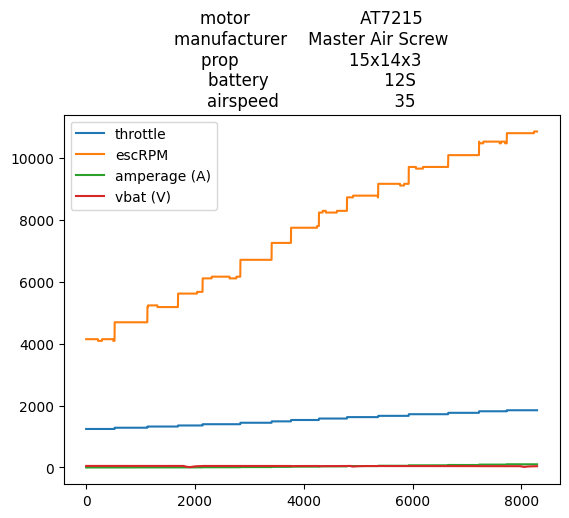

In [18]:
df = blackbox_dfs["AT7215_15x14x3_12S_35"]
df[['throttle', 'escRPM', 'amperage (A)', 'vbat (V)']].plot()
plt.title(df[['motor', 'manufacturer', 'prop', 'battery', 'airspeed']].iloc[0].to_string())

In [19]:
bins = df['throttle'].index[(df['throttle'] - df['throttle'].shift(1)).apply(lambda x: x > 20)].tolist()
print(bins)

[523, 1125, 1688, 2140, 2834, 3409, 3765, 4278, 4794, 5367, 5929, 6654, 7221, 7732]


In [20]:
df['throttle_group'] = pd.qcut(df["throttle"], q=[0] + [val / len(df["throttle"]) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
df['throttle_group']

0       523
1       523
2       523
3       523
4       523
       ... 
8284    max
8285    max
8286    max
8287    max
8288    max
Name: throttle_group, Length: 8289, dtype: category
Categories (15, object): ['523' < '1125' < '1688' < '2140' ... '6654' < '7221' < '7732' < 'max']

[665, 1335, 2068, 2684, 3262, 3972, 4475, 5054, 5612, 6186, 6799, 7394, 7960, 8338]


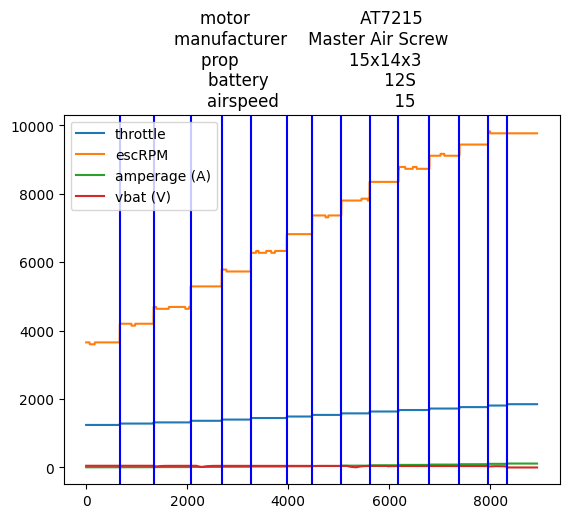

In [27]:
df = blackbox_dfs["AT7215_15x14x3_12S_15"]
df[['throttle', 'escRPM', 'amperage (A)', 'vbat (V)']].plot()
plt.title(df[['motor', 'manufacturer', 'prop', 'battery', 'airspeed']].iloc[0].to_string())
bins = df['throttle'].index[(df['throttle'] - df['throttle'].shift(1)).apply(lambda x: x > 20)].tolist()
df['throttle_group'] = pd.qcut(df["throttle"], q=[0] + [val / len(df["throttle"]) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
print(bins)
for x in bins:
    plt.axvline(x = x, color = 'b', label = 'axvline - full height')

In [28]:
df[['throttle', 'throttle_group', 'escRPM', 'amperage (A)', 'vbat (V)']].groupby('throttle_group').mean()

,throttle,escRPM,amperage (A),vbat (V)
throttle_group,,,,
665,1243.000000,3646.646617,5.678226,49.784481
1335,1283.000000,4193.843284,8.226433,49.335000
2068,1317.000000,4666.688950,10.996344,45.936262
2684,1364.000000,5291.000000,16.326266,39.686753
3262,1400.000000,5736.134948,20.658927,48.523633
3972,1445.000000,6301.977465,27.214451,48.224761
4475,1489.000000,6818.000000,34.395427,47.028887
5054,1536.000000,7358.680484,43.693161,45.383748
5612,1581.000000,7813.306452,52.955556,31.454982


In [22]:
# drop weird data
blackbox_dfs["AT7215_16x14_12S_15"] = blackbox_dfs["AT7215_16x14_12S_15"].iloc[0:8743]

In [32]:
for name in common_dfs:
    print(name)
    df = blackbox_dfs[name][['throttle', 'escRPM', 'amperage (A)', 'vbat (V)']]
    metadata = blackbox_dfs[name][['motor', 'manufacturer', 'prop', 'battery', 'airspeed']].iloc[0]
    bins = df['throttle'].index[(df['throttle'] - df['throttle'].shift(1)).apply(lambda x: x > 20)].tolist()
    # df.plot()
    # for x in bins:
    #     plt.axvline(x = x, color = 'b', label = 'axvline - full height')
    df['throttle_group'] = pd.qcut(df["throttle"], q=[0] + [val / len(df["throttle"]) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
    df = df.groupby('throttle_group').mean()
    df.reset_index(inplace=True)
    df.drop(columns=['throttle_group'], inplace=True)

    df_thrust = thrust_dfs[name][['DYNAMIC PRESSURE', 'Lift', 'Drag']]
    df_thrust['thrust'] = -df_thrust['Drag']

    df = df.join(df_thrust)
    df["percent_throttle"] = (df["throttle"] - MIN_THROTTLE) / (MAX_THROTTLE - MIN_THROTTLE) * 100
    df["motor"] = metadata["motor"]
    df["manufacturer"] = metadata["manufacturer"]
    df["prop"] = metadata["prop"]
    df["battery"] = metadata["battery"]
    df["airspeed"] = metadata["airspeed"]

    df.to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)


AT5330_16x14_12S_30
AT7215_15x14x3_12S_35
AT7215_16x14_12S_50
AT7215_16x14_12S_35
AT5330_16x16_12S_35
AT7215_16x16_12S_50
AT5330_16x16_12S_40
AT5330_15x14x3_12S_15
AT7215_16x16_12S_45
AT5330_16x14_12S_25
AT7215_15x14x3_12S_10
AT7215_15x14x3_12S_50
AT5330_15x14x3_12S_20
AT7215_16x14_12S_10
AT7215_16x14_12S_Static
AT5330_15x14x3_12S_25
AT5330_15x14x3_12S_30
AT5330_15x14x3_12S_Static
AT7215_16x14_12S_20
AT7215_15x14x3_12S_15
AT5330_16x14_12S_35
AT7215_16x14_12S_30
AT7215_15x14x3_12S_25
AT5330_15x14x3_12S_10
AT5330_16x14_12S_20
AT5330_15x14x3_12S_35
AT5330_16x16_12S_30
AT7215_15x14x3_12S_20
AT7215_16x14_12S_45
AT7215_15x14x3_12S_Static
AT7215_16x14_12S_15
AT7215_16x14_12S_40
AT7215_16x14_12S_25
AT7215_15x14x3_12S_40
AT7215_15x14x3_12S_45
AT7215_15x14x3_12S_30


/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_67277/662122406.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['throttle_group'] = pd.qcut(df["throttle"], q=[0] + [val / len(df["throttle"]) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_67277/662122406.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_thrust['thrust'] = -df_thrust['Drag']
/var/folders/gz/pp4ldsnj0tjbngm2gygkp8qc0000gn/T/ipykernel_67277/662122